#Question 1

Question 1: Perform sentiment analysis on the IMDB Movie Review Dataset Using Artificial Neural Networks (ANN).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
df_review = pd.read_csv("IMDB Dataset.csv")

In [ ]:
df_positive = df_review[df_review['sentiment'] == 'positive'][:9000]
df_negative = df_review[df_review['sentiment'] == 'negative'][:1000]
df_review_imb = pd.concat([df_positive, df_negative])

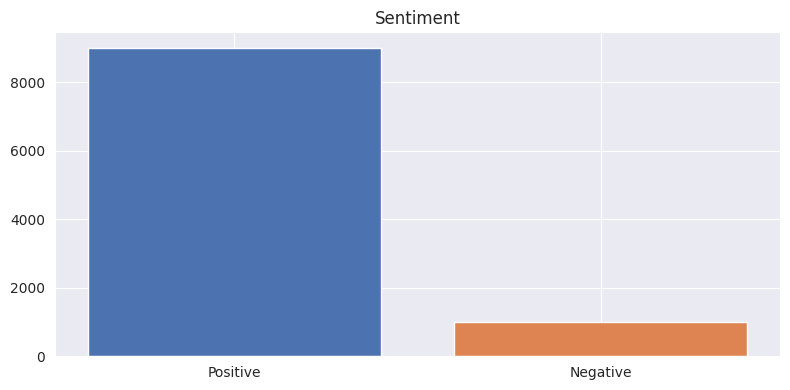

In [ ]:
colors = sns.color_palette('deep')
plt.figure(figsize=(8,4), tight_layout=True)
plt.bar(x=['Positive', 'Negative'], height=df_review_imb.value_counts(['sentiment']), color=colors[:2])
plt.title('Sentiment')
plt.savefig('sentiment.png')
plt.show()

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
df_review_bal, df_review_bal['sentiment'] = rus.fit_resample(df_review_imb[['review']], df_review_imb['sentiment'])


In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_review_bal, test_size=0.33, random_state=42)
train_x, train_y = train['review'], train['sentiment']
test_x, test_y = test['review'], test['sentiment']

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
train_x_vector = tfidf.fit_transform(train_x)
test_x_vector = tfidf.transform(test_x)

## **Building and Training the ANN Model**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelEncoder

In [ ]:
label_encoder = LabelEncoder()
train_y_enc = label_encoder.fit_transform(train_y)
test_y_enc = label_encoder.transform(test_y)

In [ ]:
model = Sequential([
    Dense(512, activation='relu', input_shape=(train_x_vector.shape[1],)),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification output layer
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_x_vector.toarray(), train_y_enc, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 354ms/step - accuracy: 0.5436 - loss: 0.6885 - val_accuracy: 0.7799 - val_loss: 0.6418
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 265ms/step - accuracy: 0.9411 - loss: 0.4639 - val_accuracy: 0.8433 - val_loss: 0.3597
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.9915 - loss: 0.0468 - val_accuracy: 0.8433 - val_loss: 0.3551
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 262ms/step - accuracy: 1.0000 - loss: 0.0049 - val_accuracy: 0.8470 - val_loss: 0.3851
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.8433 - val_loss: 0.3925
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 259ms/step - accuracy: 1.0000 - loss: 8.0524e-04 - val_accuracy: 0.8433 - val_loss: 0.4018
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 241ms/step - accuracy: 1.0000 - loss: 4.8411e-04 - val_accuracy: 0.8433 - val_loss: 0.4087
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - accuracy: 1.0000 - loss: 4.0745e-04 - v

# Question 2


## Hyperparameter Tuning for ANN Model (Question 2(a))


Part (a) - Optimize the ANN model using Grid Search or Random Search for hyperparameters such as the number of layers, learning rate, activation functions, and batch size.

In [ ]:
import keras_tuner as kt

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units', min_value=64, max_value=512, step=64), activation='relu', input_shape=(train_x_vector.shape[1],)))
    model.add(Dropout(0.5))

    for i in range(hp.Int('num_layers', 1, 3)):  # Add up to 3 additional layers
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=64, max_value=512, step=64), activation=hp.Choice('activation', ['relu', 'tanh'])))
        model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='sentiment_analysis_tuning'
)

Reloading Tuner from tuner_dir/sentiment_analysis_tuning/tuner0.json


In [ ]:
tuner.search(train_x_vector.toarray(), train_y_enc, epochs=10, validation_split=0.2)
best_model = tuner.get_best_models(num_models=1)[0]

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Model Evaluation (Question 2(b))

Part (b): Evaluate the model's performance using metrics such as accuracy, F1-score, and ROC-AUC.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [ ]:
best_predictions = best_model.predict(test_x_vector.toarray()).round().astype(int)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [ ]:
accuracy = accuracy_score(test_y_enc, best_predictions)
f1 = f1_score(test_y_enc, best_predictions)
roc_auc = roc_auc_score(test_y_enc, best_predictions)

print(f'Best Model Accuracy: {accuracy}')
print(f'Best Model F1-Score: {f1}')
print(f'Best Model ROC-AUC: {roc_auc}')

Best Model Accuracy: 0.8287878787878787
Best Model F1-Score: 0.8345534407027818
Best Model ROC-AUC: 0.8284500574052813
